Sentiment Analysis


In [ ]:

# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1d4n-igWZBpmOs_VixvaBlUcc0vn91sO6'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_sentences_100k.txt')

link2 = 'https://drive.google.com/open?id=10rFNeOcSCEQFIvLt2FpXgLO9pNdsxrBc'
fluff2, id2 = link2.split('=')
downloaded2 = drive.CreateFile({'id':id2}) 
downloaded2.GetContentFile('amazon_cells_labelled.txt')


This first code is basically just the provided data loading code with some slight modifications, in that I will tensorize the data myself

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import nltk
nltk.download("popular")
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
import os

def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, ignore_index=True)
    return data

# If this is the primary file that is executed (ie not an import of another file)
if __name__ == "__main__":
    # get data, pre-process and split
    data = pd.read_csv("train_sentences_100k.txt", delimiter='\t', header=None)
    data.columns = ['Sentence', 'Class']
    data['index'] = data.index                           # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)              # pre-process
    training_data, validation_data, training_labels, validation_labels = train_test_split( 
        # split the data into training, validation, and test splits
        data['Sentence'].values.astype('U'),
        data['Class'].values.astype('int32'),
        test_size=0.1,
        random_state=0,
        shuffle=True
    )

    trainging_data_sentences = training_data
    validation_data_sentences = validation_data
    classes = training_labels
    classes_validation = validation_labels
    

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

The code below just initializes some things and turns the training and validation data into lists so that we can manipulate it further and to prepare it for tokenization. All of this code is very standard.

In [ ]:
from collections import Counter
train_sentences = trainging_data_sentences
train_sentences = train_sentences.tolist()
validation_sentences = validation_data_sentences
validation_sentences = validation_sentences.tolist()
words = Counter()  # Dictionary that keeps track of word count


The code below will tokenize the training sentences and count the number of times each word appears and map out the dictionary, containing all the words. Tokenizing means basically taking a list of sentences on the form ['This is a sentence', 'So is this '] and turning it into: [['This', 'is', 'a', 'sentence'], ['So', 'is', 'this']]. 

We then remove words that occur less than a defined number of times. This is because words that appear like only once are likely spelling mistakes, but even if they are not, we will not have seen the word enough to determine how to use it. Lastly we make mappings of all the words in our dictionary and wich index in the dictionary each word has, and then we map our training sentences to the dictionary so that each word in each sentence basically becomes a pointer to the vocabulary. If a word in the sentence is not in the dictionary we just map it to zero.

In [ ]:
for i, sentence in enumerate(train_sentences):
    #Stores sentences as tokens
    train_sentences[i] = []
    for word in nltk.word_tokenize(sentence):  # Tokenizing the words
        words.update([word.lower()])
        train_sentences[i].append(word)


# Remove words that appear less than min_count times
min_count = 1
words = {i:j for i,j in words.items() if j>min_count}
# Sort words by frequency
words = sorted(words, key=words.get, reverse=True)
# Add padding and unknown to words
words = ['_PAD','_UNK'] + words
# Word to index and vice versa
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

for i, sentence in enumerate(train_sentences):
    # Map senteces to the dictionary
    train_sentences[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

for i, sentence in enumerate(validation_sentences):
    # For the validation sentences they must also be tokenized first
    validation_sentences[i] = [word2idx[word.lower()] if word.lower() in word2idx else 0 for word in nltk.word_tokenize(sentence)]


Lastly we will pad the sentences if the are too short or cut them short if they are too long so that each input tensor is of the same length. We will then convert our lists into numpy arrays so that we can turn them into tensors and then load them using the loader functions from Pytorch which will be useful in training because it very easily allows us to shuffle the order and do various other things.

In [ ]:
# Function to makes sentances the correct length by padding or cutting them short
def pad(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for i, review in enumerate(sentences):
        if len(review) != 0:
            features[i, -len(review):] = np.array(review)[:seq_len]
    return features

seq_len = 200  # The length that the sentences will be padded/shortened to

train_sentences = pad(train_sentences, seq_len)
val_sentences = pad(validation_sentences, seq_len)

# Converting labels into numpy arrays
train_labels = np.array(classes)
val_labels = np.array(classes_validation)

split_frac = 0.5 # 50% validation, 50% test
split_id = int(split_frac * len(val_sentences))
val_sentences, test_sentences = val_sentences[:split_id], val_sentences[split_id:]
val_labels, test_labels = val_labels[:split_id], val_labels[split_id:]

from torch.utils.data import TensorDataset, DataLoader
train_data = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
val_data = TensorDataset(torch.from_numpy(val_sentences), torch.from_numpy(val_labels))
test_data = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 100

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last= True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last = True)

The code below is code for the LSTM network that I basically just copy pasted from the end of this link: https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/. Although I have changed the validation part of the code to get an accuracy percentage. This link has very good info on LSTM networks in general and also contains links to the "Kaggle" datasest of 3.6M Amazon reviews.

In [ ]:
from matplotlib import pyplot as plt
import time
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
class SentimentNet(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

vocab_size = len(word2idx) + 1
output_size = 1
embedding_dim = 256
hidden_dim = 200
n_layers = 2

model = SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr= 0.00005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5, patience=1,verbose=True)
epochs = 50
counter = 0
clip = 5
valid_loss_min = np.Inf
early_stop_epochs = 3
accuracy = []
batch_train_loss = []
batch_val_loss = []
batch_train_accuracy = []
batch_val_accuracy = []
def model_train(epochs, lr, criterion, optimizer, clip):
    start_time = time.time()
    batch_counter_train = 0
    batch_counter_val = 0
    last_improved = 0
    valid_loss_min = np.Inf
    model.train()
    for i in range(epochs):
        running_loss_train = []
        running_loss_val = []
        running_accuracy_train = []
        running_accuracy_val = []
        if i - last_improved > early_stop_epochs-1:
            print('Early stop due to overfitting!')
            break
        h = model.init_hidden(batch_size)  
        for inputs, labels in train_loader:
            batch_counter_train += 1
            h = tuple([each.data for each in h])
            inputs, labels = inputs.to(device), labels.to(device)
            model.zero_grad()
            output, h = model(inputs, h)
            pred = torch.round(output.squeeze())
            correct_tensor = pred.eq(labels.float().view_as(pred))
            correct = np.squeeze(correct_tensor.cpu().numpy())
            loss = criterion(output.squeeze(), labels.float())
            running_accuracy_train.append(np.sum(correct))
            running_loss_train.append(loss.item())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            if batch_counter_train % 50 == 0:
              batch_train_loss.append(np.mean(running_loss_train))
              batch_train_accuracy.append(np.mean(running_accuracy_train))
              running_loss_train = []
              running_accuracy_train = []
              batch_counter_train = 0


              model.eval()
              valid_losses = []
              v_h = model.init_hidden(batch_size)
              
              for inp, lab in val_loader:
                  batch_counter_val += 1
                  v_h = tuple([each.data for each in v_h])
                  inp, lab = inp.to(device), lab.to(device)
                  output, v_h = model(inp, v_h)
                  pred = torch.round(output.squeeze())
                  correct_tensor = pred.eq(lab.float().view_as(pred))
                  correct = np.squeeze(correct_tensor.cpu().numpy())
                  val_loss = criterion(output.squeeze(), lab.float())
                  valid_losses.append(val_loss.item())
                  running_loss_val.append(val_loss.item())
                  running_accuracy_val.append(np.sum(correct))
              batch_val_loss.append(np.mean(running_loss_val))
              batch_val_accuracy.append(np.mean(running_accuracy_val))
              running_loss_val = []
              running_accuracy_val = []
   

            model.train()
        print('Epoch {} - Training loss: {} - Validation loss: {}'.format(i+1,loss, np.mean(valid_losses)))
        #If validation loss decreased save model state
        if  np.mean(valid_losses) < valid_loss_min:
            last_improved = i
            torch.save(model.state_dict(), './state_dict.pt')
            print('Minimum validation loss decreased from {:.6f} to {:.6f}. Saving new best model....'.format(valid_loss_min, np.mean(valid_losses)))
            valid_loss_min = np.mean(valid_losses)
        '''
        epoch_train_loss.append(loss)
        epoch_val_loss.append(np.mean(valid_losses))
        epoch_train_accuracy.append(100*running_accuracy_train/len(train_loader.dataset))
        epoch_val_accuracy.append(100*running_accuracy_val/len(val_loader.dataset))
        scheduler.step(loss)
        '''
        print("--- %s seconds ---" % (time.time() - start_time))
        scheduler.step(loss)
def model_test():
    accuracy = []
    # Load the best model
    model.load_state_dict(torch.load('./state_dict.pt'))
    h = model.init_hidden(batch_size)
    num_correct = 0
    #Test model on the test set
    model.eval()
    for inp, lab in test_loader:
        h = tuple([each.data for each in h])
        inp, lab = inp.to(device), lab.to(device)
        output, h = model(inp, h)
        pred = torch.round(output.squeeze())  # Rounds the output to 0/1
        correct_tensor = pred.eq(lab.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        num_correct += np.sum(correct)
    print('Model accuracy is {}%'.format(100*num_correct/len(test_loader.dataset)))

# Function to feed user input into the network
def predict_on_input(input_seq):
    model.load_state_dict(torch.load('./state_dict.pt'))
    outlist = []
    for teststr in input_seq:
        inp = [word2idx[word.lower()] if word.lower() in word2idx else 0 for word in nltk.word_tokenize(str(teststr))]
        inp = pad([inp],seq_len)
        input_tensor = torch.from_numpy(inp).to(device)
        model.eval()
        h = model.init_hidden(1)
        output, h = model(input_tensor, h)
        pred = int(torch.round(output.squeeze()))
        outlist.append(pred)
    return outlist
train_model = True

inp_sentences = ['This AI is very good', 'I find this AI is ok', 'This AI is not good']

if train_model:
    model_train(epochs, lr, criterion, optimizer, clip)
    model_test()


print(predict_on_input(inp_sentences))

      


Epoch 1 - Training loss: 0.32216086983680725 - Validation loss: 0.4486430573220156
Minimum validation loss decreased from inf to 0.448643. Saving new best model....
--- 143.20453333854675 seconds ---
Epoch 2 - Training loss: 0.4165946841239929 - Validation loss: 0.3723735918804091
Minimum validation loss decreased from 0.448643 to 0.372374. Saving new best model....
--- 287.93575048446655 seconds ---
Epoch 3 - Training loss: 0.24301427602767944 - Validation loss: 0.3259218712242282
Minimum validation loss decreased from 0.372374 to 0.325922. Saving new best model....
--- 432.58471512794495 seconds ---
Epoch 4 - Training loss: 0.18852035701274872 - Validation loss: 0.3024406125959085
Minimum validation loss decreased from 0.325922 to 0.302441. Saving new best model....
--- 577.2905113697052 seconds ---
Epoch 5 - Training loss: 0.24833868443965912 - Validation loss: 0.2873943992415253
Minimum validation loss decreased from 0.302441 to 0.287394. Saving new best model....
--- 722.078787803

[0.1641048789024353, 0.3498847782611847, 0.330980509519577]


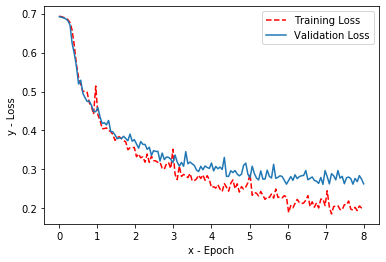

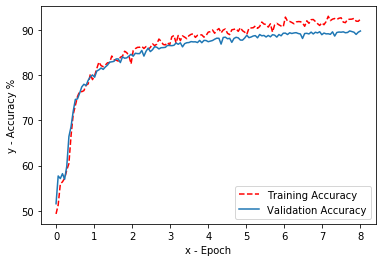

In [ ]:
from google.colab import files
ran = np.linspace(0,8,143)
plt.figure(1)
plt.plot(ran,batch_train_loss,'r--',label='Training Loss')
plt.plot(ran,batch_val_loss, label = 'Validation Loss')
plt.legend()
plt.xlabel('x - Epoch')
plt.ylabel('y - Loss')
plt.savefig("loss.png")
files.download("loss.png") 

plt.figure(2)
plt.plot(ran,batch_train_accuracy,'r--', label = 'Training Accuracy')
plt.plot(ran,batch_val_accuracy, label = 'Validation Accuracy')
plt.legend()
plt.xlabel('x - Epoch')
plt.ylabel('y - Accuracy %')
plt.savefig("val.png")
files.download("val.png") 

def predict_on_input(input_seq):
    model.load_state_dict(torch.load('./state_dict.pt'))
    outlist = []
    for teststr in input_seq:
        inp = [word2idx[word.lower()] if word.lower() in word2idx else 0 for word in nltk.word_tokenize(str(teststr))]
        inp = pad([inp],seq_len)
        input_tensor = torch.from_numpy(inp).to(device)
        model.eval()
        h = model.init_hidden(1)
        output, h = model(input_tensor, h)
        pred = float(output.squeeze())
        outlist.append(pred)
    return outlist
inp_sentences = ['The performance of this network was not bad!', 'I like this network, but the accuracy is the worst', 'The training time for this network is very bad, but the accuracy is the best!']
print(predict_on_input(inp_sentences))